# Random Forest Algorithm



The Random Forest algorithm is a popular and versatile machine learning method used for both classification and regression tasks. It is an ensemble learning method, which means it combines the predictions from multiple machine learning algorithms to make more accurate predictions than any individual model.

## Overview

A Random Forest consists of a collection of decision trees. The 'forest' generated by the Random Forest is trained through bagging, which involves training each individual tree on a different data sample. Here is how the algorithm works:

### Algorithm Steps:

1. **Bootstrap Aggregating (Bagging)**: Random Forest creates multiple decision trees and merges them together to get a more accurate and stable prediction. For each tree, a random sample of the data is selected (with replacement) to train the tree.

2. **Decision Tree Training**: Each tree in the forest is trained on its bootstrap sample. During the training of these trees, a random subset of features is selected for splitting at each node, adding to the diversity among the trees.

3. **Prediction**:
   - In classification tasks, each tree in the forest votes for a class, and the class with the most votes becomes the model's prediction.
   - In regression tasks, the average prediction of the individual trees is used.

4. **Reduction of Overfitting**: Due to the averaging of multiple trees and the random subset of features chosen for splitting, Random Forests are less likely to overfit compared to a single decision tree.

## Parameter Tuning

Key parameters in a Random Forest include:

- Number of trees in the forest (`n_estimators`)
- Maximum depth of trees (`max_depth`)
- Minimum samples required to split an internal node (`min_samples_split`)
- Minimum samples required to be at a leaf node (`min_samples_leaf`)
- Number of features to consider when looking for the best split (`max_features`)

Optimizing these parameters can significantly impact the performance of a Random Forest model.

## Advantages

- Handles both classification and regression tasks.
- Provides a good indicator of feature importance.
- Handles missing values and maintains accuracy for missing data.
- Less likely to overfit.

## Disadvantages

- Complexity: More complex than Decision Trees.
- Computationally intensive, especially with a large number of trees.
- Less intuitive: The decision-making process is not as easy to understand compared to a single decision tree.


In [39]:
# Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import spacy
import re
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [40]:
data = pd.read_csv("article_level_data.csv" , index_col= False )
data = data.drop(columns=["Unnamed: 0"])
data.head()

,article,class
0,NLP is a multidisciplinary field that draws fr...,0
1,There are a variety of emerging applications f...,0
2,As each new means of communication and social ...,0
3,"These suggestions include:, Learn about the pu...",0
4,In recent years there has been growing concern...,0


## TF-IDF

### Preprocess

In [41]:
def lowering(text):
    return text.lower()

data['article_clean'] = data.article.apply(lowering)   

In [42]:
len(data[data.article_clean.str.contains('http')]) # there are 23 links, we can remove or not them, to be decided

23

In [43]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

data['article_clean'] = data.article_clean.apply(remove_url)

In [44]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

data['article_clean'] = data.article_clean.apply(remove_accents)

In [45]:
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

data['article_clean'] = data.article_clean.apply(remove_punctuation)

In [46]:
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

data['article_clean'] = data.article_clean.apply(remove_extra_spaces)
data['article_nopunct'] = data.article_clean.copy()

In [47]:
# Spacy: 326 words to eliminate
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [48]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
data['article_clean'] = data.article_clean.apply(delete_stopwords)

In [49]:
def stemming(text):
    # Tokenization
    words = word_tokenize(text)
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruct the text after stemming
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

In [50]:
# create a new DataFrame called df, dropping the columns that we don't want to use from the original dataset
df = data.drop(columns=["article"])

# reorders the columns
df = df[['article_clean', 'class']]

df.head()

,article_clean,class
0,nlp multidisciplinary field draws linguistics ...,0
1,variety emerging applications nlp including fo...,0
2,new means communication social interaction int...,0
3,suggestions include learn purpose newsgroup po...,0
4,recent years growing concern internet users ev...,0


In [51]:
# Apply the stemming function to the 'abstract_clean' column
df['article_clean'] = df['article_clean'].apply(stemming)
df.head()

,article_clean,class
0,nlp multidisciplinari field draw linguist comp...,0
1,varieti emerg applic nlp includ follow voic co...,0
2,new mean commun social interact introduc socia...,0
3,suggest includ learn purpos newsgroup post gro...,0
4,recent year grow concern internet user eventu ...,0


Performing a TF-IDF (Term Frequency-Inverse Document Frequency) transformation using the scikit-learn library.
Our primary objective is to analyze the textual content of the "article_clean" column of the DataFrame named "df".

Next, we propose to augment the DataFrame by incorporating the TF-IDF matrix derived from this analysis. This augmented DataFrame will serve as the basis for training our random forest.

In [52]:
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  

# Apply TF-IDF to the 'sentence_clean' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['article_clean'])

# Convert the sparse matrix to a dense representation
dense_tfidf_matrix = tfidf_matrix.todense()

# Add the resulting dense matrix as columns to the DataFrame
df = pd.concat([df, pd.DataFrame(dense_tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())], axis=1)

In [53]:
# Now we drop the 'abstract_clean' column because we don't need it anymore
df = df.drop(columns=["article_clean"])
df.head(10)

,class,00,000,05,06,0stripe,10,100,101,1012,1015,102,1024,106,10see,11,1101001,111,11101001,11111,115,11a,11b,11see,12,120,1200,123,128,13,130,135particular,137while,1394,14,144,147,148,15,150,155,16,160,162,165,166,17,175,18,180,...,wrote,wsdl,wto,www,wysiwyg,x10,xbox,xcode,xcopi,xd,xerox,xga,xhtm,xiaomi,xiv,xml,xmodem,xnu,xor,xp,xperia,xrml,y2k,yahoo,yang,yard,ye,year,yellow,yield,york,young,younger,youngster,youtub,yukihiro,z1,z2,z3,z4,zdnet,zero,zimmermann,zip,zone,zoom,zsoft,zuckerberg,zuse,zuseus
0,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.1076,0.0,0.0,0.0,0.092603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [54]:
# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


### Spliting data

In [55]:
df = df.loc[:, ~df.columns.duplicated()] # remove duplicates columns

# 'class' is the target variable and the rest of the columns are used as features
X = df.drop('class', axis=1)
y = df['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

### Random Forest

In [56]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest.
    'max_depth': [10, 20, None],       # Maximum number of levels in tree.
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node.
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split.
    'bootstrap': [True, False]         # Method of selecting samples for training each tree.
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_grid = grid_search.best_estimator_
y_train_pred = best_grid.predict(X_train)  
y_val_pred = best_grid.predict(X_val)
y_test_pred = best_grid.predict(X_test)

# Evaluate the best model after hyperparameter tuning
print("Tuned Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Tuned Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Tuned Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; tota

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_f

/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
486 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
425 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Tuned Training Accuracy: 0.9983606557377049
Tuned Validation Accuracy: 0.8676470588235294
Tuned Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       103
           1       0.84      0.90      0.87       101

    accuracy                           0.87       204
   macro avg       0.87      0.87      0.87       204
weighted avg       0.87      0.87      0.87       204

Tuned Test Accuracy: 0.8823529411764706
Tuned Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       104
           1       0.87      0.89      0.88       100

    accuracy                           0.88       204
   macro avg       0.88      0.88      0.88       204
weighted avg       0.88      0.88      0.88     

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier with the best parameters found
rf_classifier = RandomForestClassifier(
    n_estimators=best_grid.n_estimators,
    max_depth=best_grid.max_depth,
    min_samples_split=best_grid.min_samples_split,
    min_samples_leaf=best_grid.min_samples_leaf,
    max_features=best_grid.max_features,
    bootstrap=best_grid.bootstrap,
    random_state=42
)

# Perform k-fold cross-validation
# cv=5 denotes 5 folds
# scoring='accuracy' uses accuracy as the metric for evaluation
scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracies for each fold:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score}")

# The mean score and the 95% confidence interval of the score estimate are then calculated
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracies for each fold:
Fold 1: 0.8921568627450981
Fold 2: 0.9068627450980392
Fold 3: 0.8431372549019608
Fold 4: 0.8029556650246306
Fold 5: 0.896551724137931
Accuracy: 0.87 (+/- 0.08)


### Plotting of results

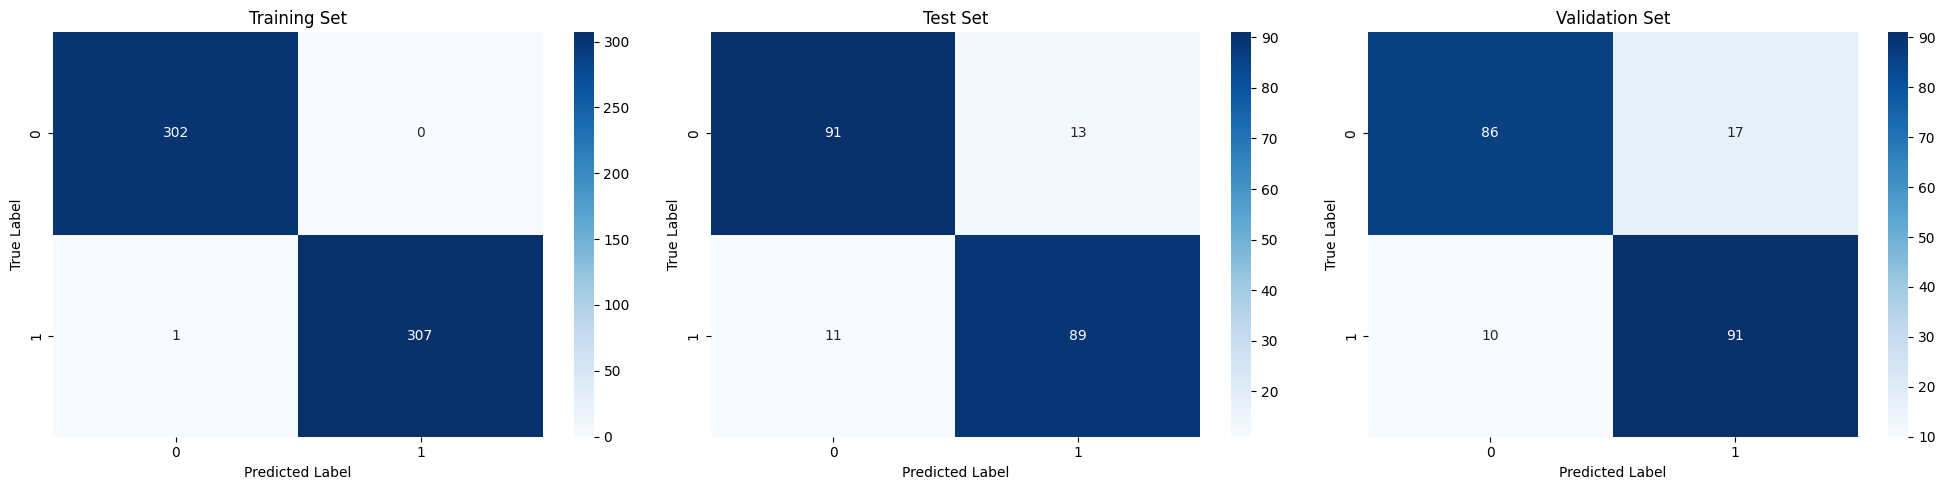

In [58]:
# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot confusion matrices
plt.sca(axes[0])
plot_confusion_matrix(conf_matrix_train, 'Training Set')

plt.sca(axes[1])
plot_confusion_matrix(conf_matrix_test, 'Test Set')

plt.sca(axes[2])
plot_confusion_matrix(conf_matrix_val, 'Validation Set')
plt.tight_layout()
plt.show()


## Using new features

List of features to extract: 
1. Features that identify diversity and richness in the vocabulary (if we have to choose, keep Herdan's C, it's the best one for the task according to a paper)
    - Herdan's C
    - MaaS
    - Simpson's index

2. Perplexity 
3. Grammar Score 
4. N-grams distribution -> in the end no: it's shit to be summarized (the means are all low and don't make distinctions between Human and AI)
5. Type Token Ratio (TTR) on N-grams for N=1,2,3
6. Length (article - level: done in the eda, column 'words')
7. Average token length

Everything done on partially pre-procesed articles: only no punctuation but we keep the stopwords.

Before getting the features, we add some columns to the dataset that containg infromations needed to compute more then one feature. We will drop these columns afterwards. 

### Random Forest with new features

Read the dataset with the new computed features

In [65]:
data = pd.read_csv('data1000_withfeatures.csv')

In [66]:
df_features = data.copy()
df_features = df_features.drop(columns=[ "article", "article_clean", "article_nopunct", "article_list"])
df_features.head(5)

,Unnamed: 0,class,length,words,sentences,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,0,0,1112,187,6,1.778976,0.218939,0.984157,0.021390,0.609626,0.988235,1.0,4.804348,35.369075
1,1,0,630,82,2,2.111778,0.263233,0.978882,0.036585,0.768293,1.000000,1.0,6.250000,58.814785
2,2,0,1135,176,8,1.799834,0.222197,0.985182,0.022727,0.693182,0.989691,1.0,5.285714,53.423985
3,3,0,1018,173,10,1.805839,0.223120,0.986100,0.034682,0.647399,0.987013,1.0,4.779762,34.250844
4,4,0,699,111,3,1.975996,0.246963,0.982225,0.027027,0.702703,0.983607,1.0,5.284404,25.693995


Split the data into training / test / validation sets

In [67]:
# 'class' is the target variable and the rest of the columns are used as features
X = df_features.drop('class', axis=1)
y = df_features['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

### Random Forest

In [68]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest.
    'max_depth': [10, 20, None],       # Maximum number of levels in tree.
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node.
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split.
    'bootstrap': [True, False]         # Method of selecting samples for training each tree.
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_grid = grid_search.best_estimator_
y_train_pred = best_grid.predict(X_train)  
y_val_pred = best_grid.predict(X_val)
y_test_pred = best_grid.predict(X_test)

# Evaluate the best model after hyperparameter tuning
print("Tuned Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Tuned Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Tuned Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; tota

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_feat

/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
486 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
224 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/edo/anaconda3/envs/fds_final/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Training Accuracy: 1.0
Tuned Validation Accuracy: 1.0
Tuned Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       101

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204

Tuned Test Accuracy: 0.9950980392156863
Tuned Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       104
           1       0.99      1.00      1.00       100

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier with the best parameters found
rf_classifier = RandomForestClassifier(
    n_estimators=best_grid.n_estimators,
    max_depth=best_grid.max_depth,
    min_samples_split=best_grid.min_samples_split,
    min_samples_leaf=best_grid.min_samples_leaf,
    max_features=best_grid.max_features,
    bootstrap=best_grid.bootstrap,
    random_state=42
)

# Perform k-fold cross-validation
# cv=5 denotes 5 folds
# scoring='accuracy' uses accuracy as the metric for evaluation
scores = cross_val_score(rf_classifier, X, y, cv=10, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracies for each fold:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score}")

# The mean score and the 95% confidence interval of the score estimate are then calculated
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracies for each fold:
Fold 1: 0.8235294117647058
Fold 2: 1.0
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 1.0
Fold 7: 1.0
Fold 8: 1.0
Fold 9: 1.0
Fold 10: 0.7722772277227723
Accuracy: 0.96 (+/- 0.16)


### Plotting

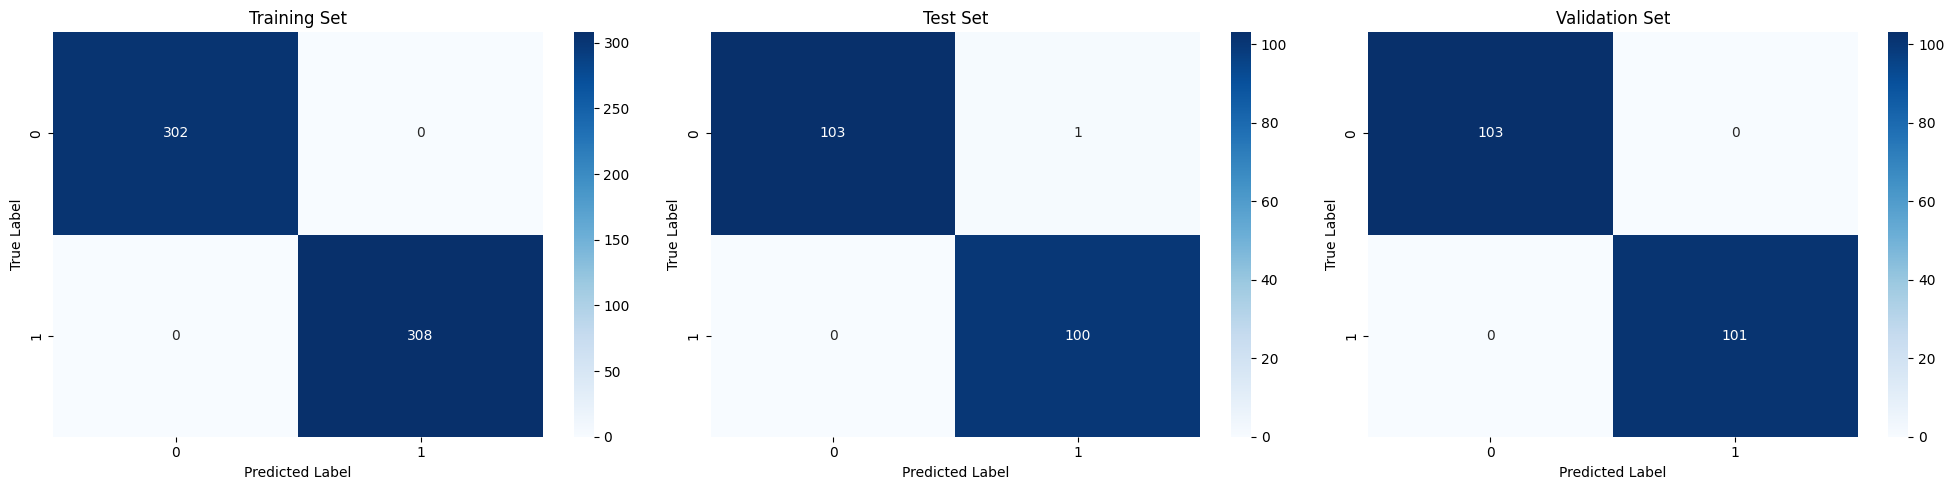

In [70]:
# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot confusion matrices
plt.sca(axes[0])
plot_confusion_matrix(conf_matrix_train, 'Training Set')

plt.sca(axes[1])
plot_confusion_matrix(conf_matrix_test, 'Test Set')

plt.sca(axes[2])
plot_confusion_matrix(conf_matrix_val, 'Validation Set')
plt.tight_layout()
plt.show()
